# Brain Tumor Detection using Convolutional Neural Network

### Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
from absl import logging
logging._warn_preinit_stderr = 0
logging.warning('Worrying Stuff')

## Data Preparation & Preprocessing¶
### Step 1: Cropping the part of the image that contains the brain
    This was done using a cropping technique to find the extreme top, bottom, left and right points of the brain using OpenCV.

In [3]:
#Function to crop the image
def crop_img(image, plot = False):
    #Convert the img to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    #threshold the image 
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    #performing morphological operations dilation and erosion to remove any small regions of noise
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations = 2)
    
    #find contours in the thresholded image, find the maximum one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

#### Applying the crop function to an image from the dataset

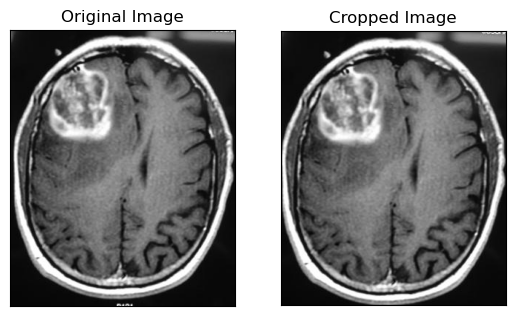

In [4]:
ex_img = cv2.imread('dataset/yes/Y15.jpg')
ex_new_img = crop_img(ex_img, True)

### Step 2: Resizing the images
### Step 3: Apply Normalization

    The function below does the following:
    1. Read the image
    2. Crop the part of the image containing only the brain
    3. Resize the image (because the image in the dataset is of different sizes (width, height and # of channels) so we want
       all our images to be of size(240,240,3) to feed it as an input to the neural network
    4. Apply normalization as we want our pixel values to be scaled to the range 0-1
    5. Append the image to X and its label to y
    After that shuffle X and y, because our data is ordered(i.e. the arrays contain the first part belonging to one class(Yes)     and the second belonging to the other(No).
    Finally, return X and y

In [5]:
def load_data(dir_list, image_size):
    '''
        Arguements: 
            dir_list: list of strings representing file directories
            image_size: image width, image height
        Returns:
            X: a numpy array with shape = (#_of_examples, img_width, img_height, #_of_channels)
            y: a numpy array with shape = (#_of_examples, 0/1)
    '''
    X = []
    y = []
    img_width, img_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + "\\" + filename)
            image = crop_img(image, plot = False)
            image = cv2.resize(image, dsize = (img_width, img_height), interpolation=cv2.INTER_CUBIC)
            #normalize values
            image = image/255
            #append the image to X
            X.append(image)
            #append a value of 1 into the target array 
            #if image is in folder named 'yes' otherwise append 0
            if(directory[-3:] == 'yes'):
                y.append([1])
            else:
                y.append([0])
        
    X = np.array(X)
    y = np.array(y)
    
    #shuffle the data
    X, y = shuffle(X,y)
    
    print(f"Number of examples: {len(X)}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y

In [6]:
#img = cv2.imread('augmented_data/yes/aug_Y100_0_2716.jpg')
#img.shape

#### We load up the augmented data that we generated in the Data Augmentation notebook

In [7]:
augmented_path = 'augmented_data/'

#augmented data contains both the original images and newly generated images
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240,240)

X, y = load_data([augmented_yes, augmented_no], [IMG_WIDTH, IMG_HEIGHT])

Number of examples: 1451
X shape: (1451, 240, 240, 3)
y shape: (1451, 1)


##### As we see we have 2064 images. Each image is of shape (240, 240, 3) = (img_width, img_height, # of channels.

### Plotting some example images

In [8]:
def plot_example_images(X, y, n = 50):
    '''
        Plot n sample images for both values of y
        X: a numpy array with shape = (#_of_examples, img_width, img_height, #_of_channels)
        y: a numpy array with shape = (#_of_examples, 0/1)
    '''
    
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_imgs = images[:n]
        
        cols = 10
        rows = int(n/cols)
        
        plt.figure(figsize = (20,10))
        
        i = 1;
        for image in n_imgs:
            plt.subplot(rows, cols, i)
            plt.imshow(image[0])
            
            #remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [9]:
print(X.shape)

(1451, 240, 240, 3)


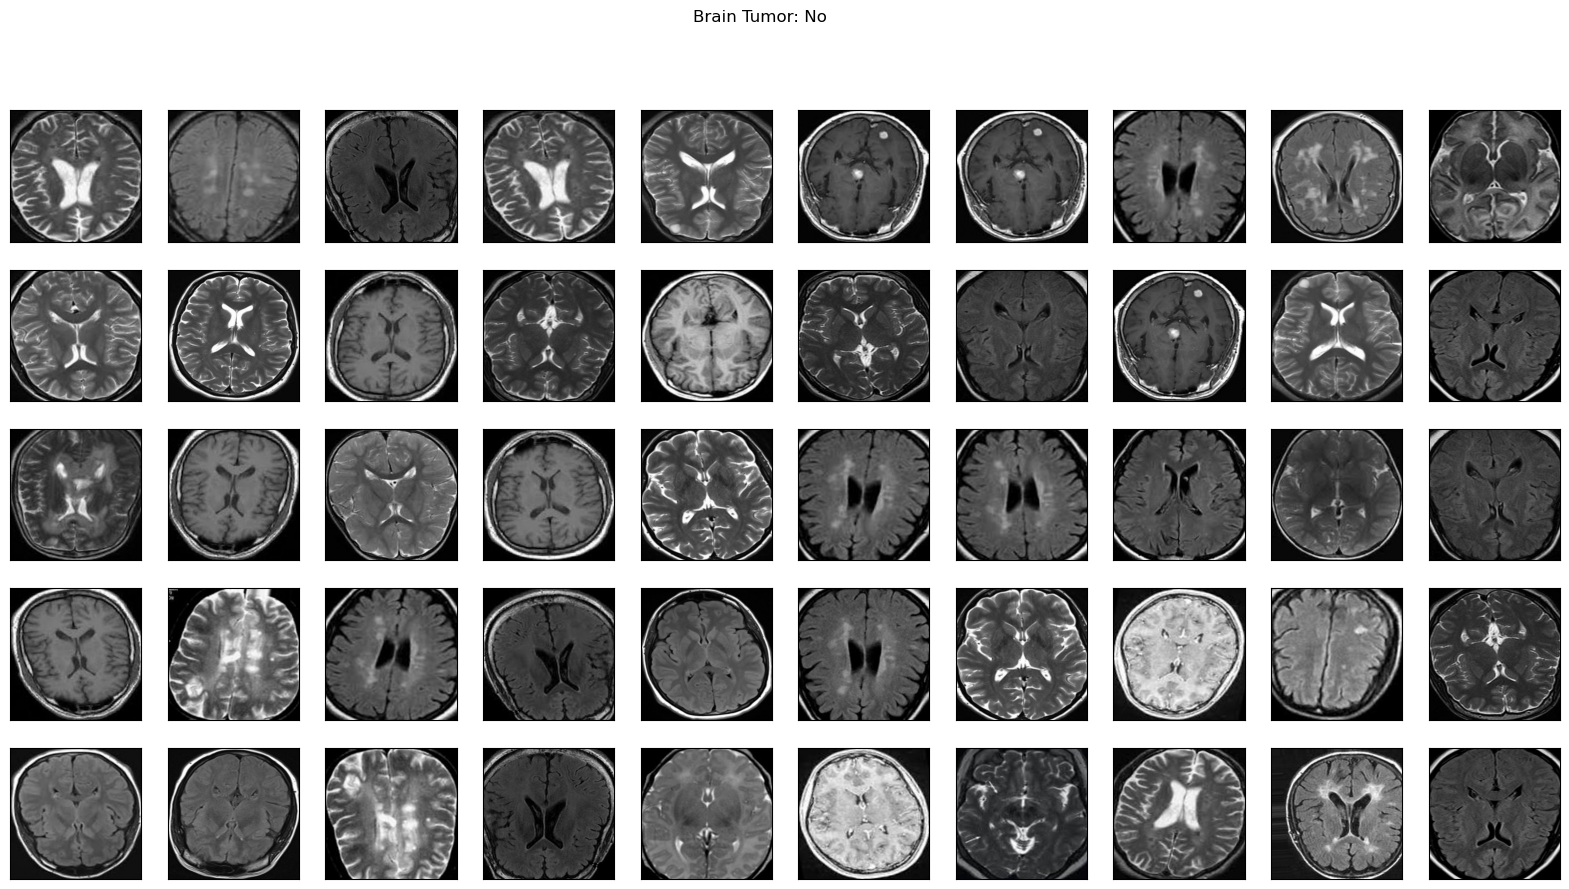

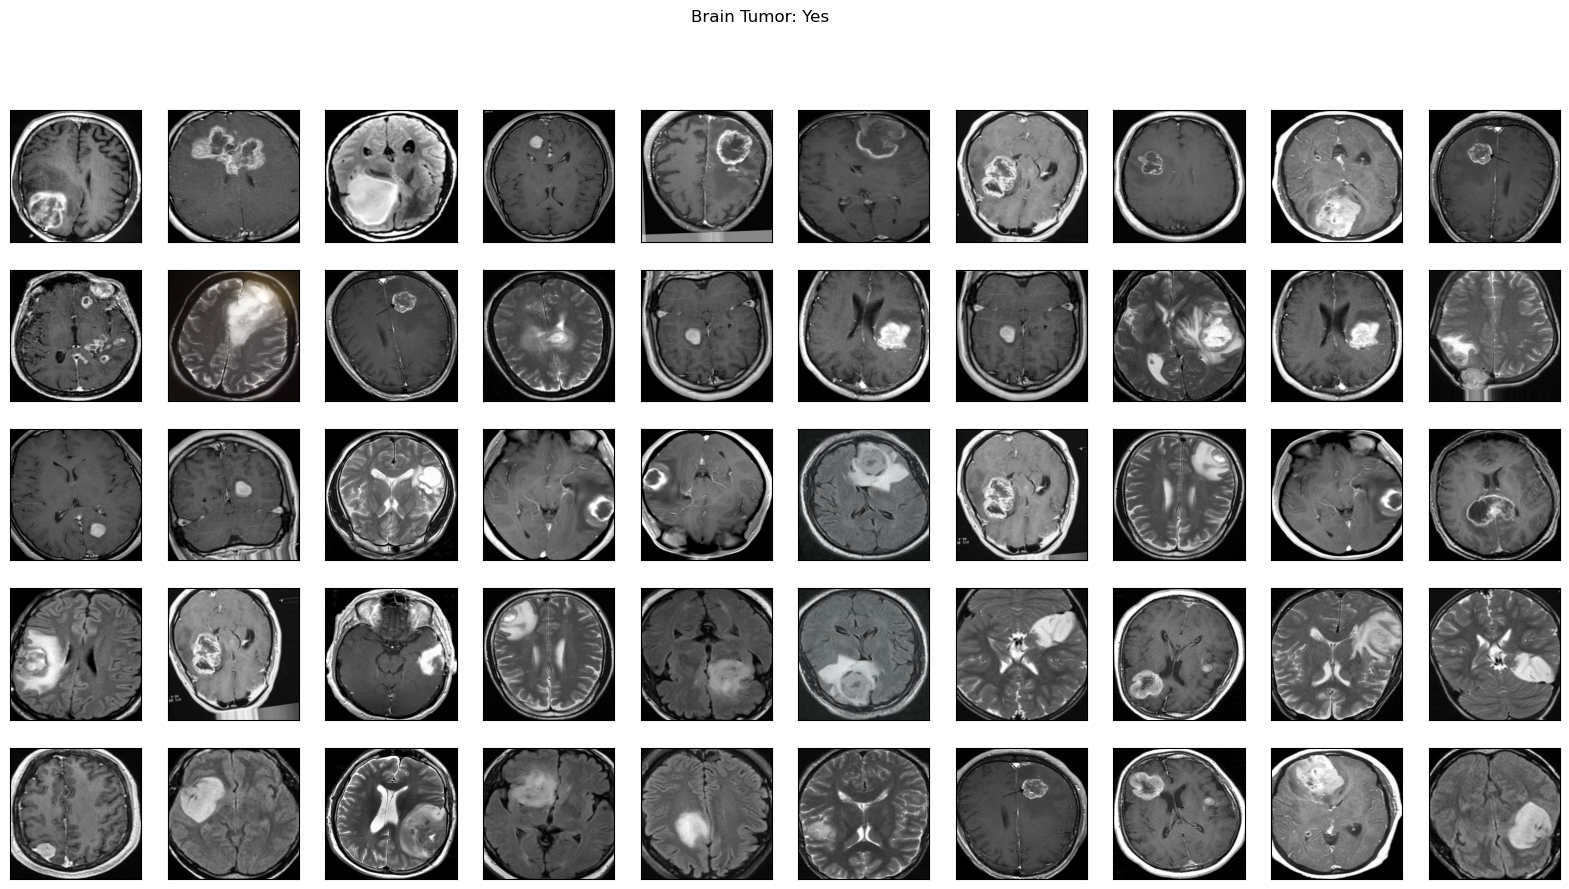

In [10]:
plot_example_images(X, y)

### Split the data
    Split X, y into training, validation and testing sets

In [11]:
def split_data(X, y, test_size = 0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

#### We split our data as follows:
        1. 70% data for training
        2. 15% data for validation
        3. 15% data for testing

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size = 0.3)

In [13]:
print("Number of training examples = " + str(X_train.shape[0]))
print("Number of validation examples = " + str(X_val.shape[0]))
print("Number of testing examples = " + str(X_test.shape[0]))
print("X_train shape = " + str(X_train.shape))
print("y_train shape = " + str(y_train.shape))
print("X_val shape = " + str(X_val.shape))
print("y_val shape = " + str(y_val.shape))
print("X_test shape = " + str(X_test.shape))
print("y_test shape = " + str(y_test.shape))

Number of training examples = 1015
Number of validation examples = 218
Number of testing examples = 218
X_train shape = (1015, 240, 240, 3)
y_train shape = (1015, 1)
X_val shape = (218, 240, 240, 3)
y_val shape = (218, 1)
X_test shape = (218, 240, 240, 3)
y_test shape = (218, 1)


### Some helper functions

In [14]:
def hms_string(sec_elapsed):
    h = (int)(sec_elapsed / (60 * 60))
    m = (int)((sec_elapsed % (60*60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s, 1)}"

In [15]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)
    
    return score

# Build the CNN Model

In [16]:
def build_model(input_shape):
    '''
    Arguements:
        input_shape: A tuple representing shape of the input of the model. shape=(img_width, img_height, # of channels)
    Returns:
        model: A model object
    '''
    
    #define a tensor with shape as input_shape
    X_input = Input(input_shape)
    
    #zero padding
    X = ZeroPadding2D((2,2))(X_input)
    #shape becomes (?, 244, 244, 3)
    
    X = Conv2D(32, (7,7), strides = (1,1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    
    # FLATTEN X 
    X = Flatten()(X) 
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [17]:
IMG_SHAPE = (240, 240, 3)

In [18]:
model = build_model(IMG_SHAPE)

In [19]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [20]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'

In [22]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
#filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.3f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [23]:
start_time = time.time()
model.fit(x=X_train,y=y_train,batch_size = 32, epochs=5, validation_data=(X_val, y_val), callbacks = [checkpoint])

end_time = time.time()
exec_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(exec_time)}")

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 1.1114 - accuracy: 0.6039

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.417.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.417.model\assets


32/32 [==============================] - 62s 2s/step - loss: 1.1114 - accuracy: 0.6039 - val_loss: 0.7709 - val_accuracy: 0.4174
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.7300

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.674.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.674.model\assets


32/32 [==============================] - 57s 2s/step - loss: 0.5288 - accuracy: 0.7300 - val_loss: 0.6147 - val_accuracy: 0.6743
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8138

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.647.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.647.model\assets


32/32 [==============================] - 57s 2s/step - loss: 0.4146 - accuracy: 0.8138 - val_loss: 0.6214 - val_accuracy: 0.6468
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8227

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.720.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.720.model\assets


32/32 [==============================] - 57s 2s/step - loss: 0.3954 - accuracy: 0.8227 - val_loss: 0.5537 - val_accuracy: 0.7202
Epoch 5/5
32/32 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8739

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.720.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.720.model\assets


32/32 [==============================] - 59s 2s/step - loss: 0.3227 - accuracy: 0.8739 - val_loss: 0.5348 - val_accuracy: 0.7202
Elapsed time: 0:4:54.0


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.8906

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.706.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.706.model\assets


32/32 [==============================] - 60s 2s/step - loss: 0.2902 - accuracy: 0.8906 - val_loss: 0.5516 - val_accuracy: 0.7064
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8749

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.647.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.647.model\assets


32/32 [==============================] - 59s 2s/step - loss: 0.3062 - accuracy: 0.8749 - val_loss: 0.6957 - val_accuracy: 0.6468
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9133

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.651.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.651.model\assets


32/32 [==============================] - 57s 2s/step - loss: 0.2345 - accuracy: 0.9133 - val_loss: 0.7071 - val_accuracy: 0.6514
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9182

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.711.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.711.model\assets


32/32 [==============================] - 57s 2s/step - loss: 0.2301 - accuracy: 0.9182 - val_loss: 0.6054 - val_accuracy: 0.7110
Epoch 5/5
32/32 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9310

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.720.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.720.model\assets


32/32 [==============================] - 59s 2s/step - loss: 0.2078 - accuracy: 0.9310 - val_loss: 0.5990 - val_accuracy: 0.7202
Elapsed time: 0:4:53.7


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9340

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.789.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.789.model\assets


32/32 [==============================] - 60s 2s/step - loss: 0.1683 - accuracy: 0.9340 - val_loss: 0.4616 - val_accuracy: 0.7890
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9409

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.716.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.716.model\assets


32/32 [==============================] - 58s 2s/step - loss: 0.1604 - accuracy: 0.9409 - val_loss: 0.7149 - val_accuracy: 0.7156
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9458

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.826.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.826.model\assets


32/32 [==============================] - 58s 2s/step - loss: 0.1527 - accuracy: 0.9458 - val_loss: 0.4035 - val_accuracy: 0.8257
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9468

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.803.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.803.model\assets


32/32 [==============================] - 57s 2s/step - loss: 0.1499 - accuracy: 0.9468 - val_loss: 0.4888 - val_accuracy: 0.8028
Epoch 5/5
32/32 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9645

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.789.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.789.model\assets


32/32 [==============================] - 58s 2s/step - loss: 0.1185 - accuracy: 0.9645 - val_loss: 0.4964 - val_accuracy: 0.7890
Elapsed time: 0:4:53.0


In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9616

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.826.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.826.model\assets


32/32 [==============================] - 59s 2s/step - loss: 0.1177 - accuracy: 0.9616 - val_loss: 0.4516 - val_accuracy: 0.8257
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9773

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.867.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.867.model\assets


32/32 [==============================] - 59s 2s/step - loss: 0.0915 - accuracy: 0.9773 - val_loss: 0.3570 - val_accuracy: 0.8670
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9714

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.862.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.862.model\assets


32/32 [==============================] - 58s 2s/step - loss: 0.0883 - accuracy: 0.9714 - val_loss: 0.3697 - val_accuracy: 0.8624
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9754

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.794.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.794.model\assets


32/32 [==============================] - 58s 2s/step - loss: 0.0844 - accuracy: 0.9754 - val_loss: 0.6498 - val_accuracy: 0.7936
Epoch 5/5
32/32 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.9448

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.867.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.867.model\assets


32/32 [==============================] - 59s 2s/step - loss: 0.1303 - accuracy: 0.9448 - val_loss: 0.3585 - val_accuracy: 0.8670
Elapsed time: 0:4:52.9


In [27]:
history = model.history.history

In [28]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [29]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

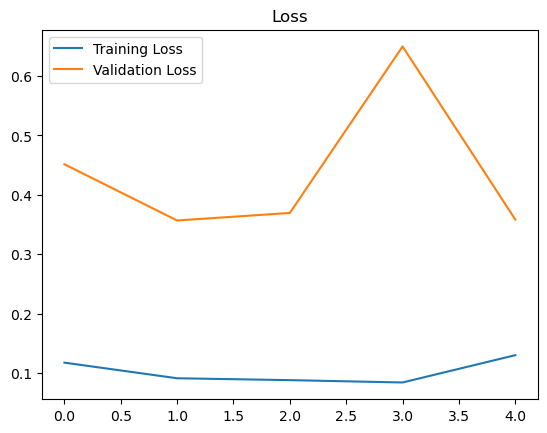

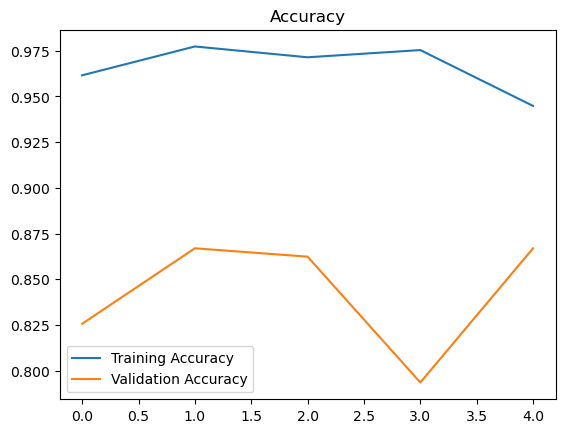

In [30]:
plot_metrics(history)

## Results
    We experiment with the best model (best validation accuracy)
    We load model with accuracy 90%

### Load the best model

In [31]:
best_model = load_model(filepath="models/cnn-parameters-improvement-05-0.90.model")

In [32]:
best_model.metrics_names

['loss', 'accuracy']

In [33]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

7/7 [==============================] - 3s 381ms/step - loss: 0.2302 - accuracy: 0.9083


### Accuracy of the best model on the testing data

In [34]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.23022058606147766
Test Accuracy = 0.9082568883895874


### F1 score for the best model on the testing data

In [35]:
y_test_prob = best_model.predict(X_test)

7/7 [==============================] - 3s 357ms/step


In [36]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8958333333333334


#### F1 score on the validation data

In [37]:
y_val_prob = best_model.predict(X_val)

7/7 [==============================] - 2s 351ms/step


In [38]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8333333333333334


### Results Interpretation

In [39]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [40]:
data_percentage(y)

Number of examples: 1451
Percentage of positive examples: 41.48862853204687%, number of pos examples: 602
Percentage of negative examples: 58.51137146795313%, number of neg examples: 849


In [41]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1015
Percentage of positive examples: 41.576354679802954%, number of pos examples: 422
Percentage of negative examples: 58.423645320197046%, number of neg examples: 593
Validation Data:
Number of examples: 218
Percentage of positive examples: 39.908256880733944%, number of pos examples: 87
Percentage of negative examples: 60.091743119266056%, number of neg examples: 131
Testing Data:
Number of examples: 218
Percentage of positive examples: 42.6605504587156%, number of pos examples: 93
Percentage of negative examples: 57.3394495412844%, number of neg examples: 125


## Conclusion
    The model predicts brain tumor with:
    93% accuracy on the test set
    0.93 f1 score on the test set
    
### Performance table:
            Validation set	  Test set
            Accuracy	94%	    93.8%
            F1 score	0.94	0.93

In [47]:
#Making a single prediction test
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('dataset/yes/y23.jpg', target_size = (240,240))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = best_model.predict(test_image)
result

1/1 [==============================] - 0s 33ms/step


array([[0.699766]], dtype=float32)

In [48]:
if result[0]<=0.5:
    print("No BrainTumor")
else:
    print("BrainTumor")

BrainTumor


In [49]:
#save model
model.save('brain_tumor_model.h5')